In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.autoencoder import Autoencoder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import struct
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        # Read images
        with open(images_path, 'rb') as f:
            magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
            self.images = np.frombuffer(f.read(), dtype=np.uint8).reshape(size, rows, cols)

        # Read labels
        with open(labels_path, 'rb') as f:
            magic, size = struct.unpack(">II", f.read(8))
            self.labels = np.frombuffer(f.read(), dtype=np.uint8)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        else:
            # Convert to tensor and normalize to [0,1]
            image = torch.FloatTensor(image) / 255.0
            image = image.unsqueeze(0)  # Add channel dimension
        
        # Convert label to tensor as well
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return image, label
    
# Create dataset
train_dataset = MNISTDataset(
    images_path='../data/mnist/train-images-idx3-ubyte/train-images-idx3-ubyte',
    labels_path='../data/mnist/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    transform=None
)

# Create dataloader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [4]:
# Modify autoencoder for MNIST (1 channel, 28x28 images)
autoencoder = Autoencoder(
    input_channels=1,
    hidden_dim_1=64,
    hidden_dim_2=32,
    latent_dim=16,
)

In [5]:
sample_data, _ = next(iter(train_loader))
print("Input data shape:", sample_data.shape)  # Should be [32, 1, 28, 28]
reconstructed, latent = autoencoder(sample_data)
print("Reconstructed shape:", reconstructed.shape)
print("Latent shape:", latent.shape)


Input data shape: torch.Size([32, 1, 28, 28])
Reconstructed shape: torch.Size([32, 1, 28, 28])
Latent shape: torch.Size([32, 16, 28, 28])


/var/folders/5g/_0nnj_t54m30pxpk83wpms6r0000gn/T/ipykernel_5394/2403316052.py:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  image = torch.FloatTensor(image) / 255.0


In [10]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
num_epochs = 1


In [11]:
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Print shapes for first batch of first epoch
        if epoch == 0 and batch_idx == 0:
            print("Batch data shape:", data.shape)
        
        data = data.to(device)
        
        # Forward pass
        reconstructed, latent = autoencoder(data)
        
        # Print shapes for first batch of first epoch
        if epoch == 0 and batch_idx == 0:
            print("Reconstructed shape:", reconstructed.shape)
            print("Original data shape:", data.shape)
        
        loss = criterion(reconstructed, data)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.6f}')
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch}, Average Loss: {avg_loss:.6f}')

Batch data shape: torch.Size([32, 1, 28, 28])
Reconstructed shape: torch.Size([32, 1, 28, 28])
Original data shape: torch.Size([32, 1, 28, 28])
Epoch: 0, Batch: 0, Loss: 0.000026
Epoch: 0, Batch: 100, Loss: 0.000048
Epoch: 0, Batch: 200, Loss: 0.000031
Epoch: 0, Batch: 300, Loss: 0.000029
Epoch: 0, Batch: 400, Loss: 0.000028
Epoch: 0, Batch: 500, Loss: 0.000029
Epoch: 0, Batch: 600, Loss: 0.000027
Epoch: 0, Batch: 700, Loss: 0.000023
Epoch: 0, Batch: 800, Loss: 0.000024
Epoch: 0, Batch: 900, Loss: 0.000028
Epoch: 0, Batch: 1000, Loss: 0.000021
Epoch: 0, Batch: 1100, Loss: 0.000032
Epoch: 0, Batch: 1200, Loss: 0.000020
Epoch: 0, Batch: 1300, Loss: 0.000059
Epoch: 0, Batch: 1400, Loss: 0.000036
Epoch: 0, Batch: 1500, Loss: 0.000025
Epoch: 0, Batch: 1600, Loss: 0.000018
Epoch: 0, Batch: 1700, Loss: 0.000016
Epoch: 0, Batch: 1800, Loss: 0.000028
Epoch: 0, Average Loss: 0.000050


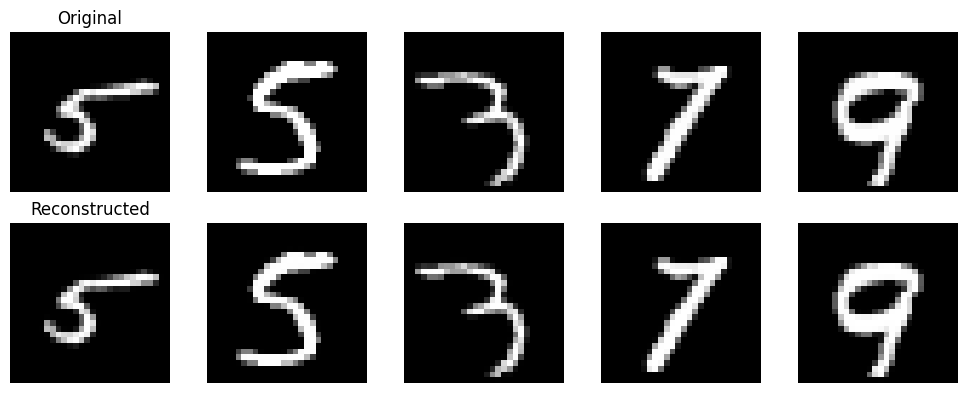

In [12]:
import matplotlib.pyplot as plt

def show_image_reconstruction(autoencoder, dataloader, device, num_images=5):
    # Get a batch of images
    images, _ = next(iter(dataloader))
    
    # Select the first num_images
    images = images[:num_images].to(device)
    
    # Get reconstructions
    with torch.no_grad():
        reconstructed, _ = autoencoder(images)
    
    # Move tensors to CPU and convert to numpy for plotting
    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    # Plot original and reconstructed images
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i][0], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
    
    plt.tight_layout()
    plt.show()

# Sample and display images
show_image_reconstruction(autoencoder, train_loader, device)

# If you want to save a specific reconstruction
def save_reconstruction(image_path, autoencoder, image, device):
    with torch.no_grad():
        # Add batch dimension if needed
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        image = image.to(device)
        reconstructed, _ = autoencoder(image)
        
        # Save the reconstructed image
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(image[0][0].cpu(), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[0][0].cpu().numpy(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
        
        plt.savefig(image_path)
        plt.close()

# Example usage:
# sample_image, _ = next(iter(train_loader))
# save_reconstruction('reconstruction.png', autoencoder, sample_image[0], device)

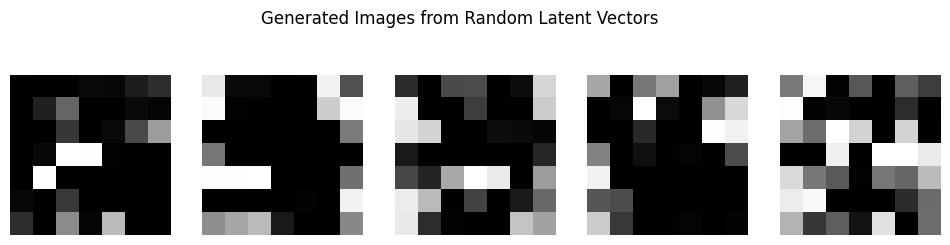

In [17]:
def generate_from_latent(autoencoder, device, num_images=5):
    # Sample random latent vectors
    latent_size = (num_images, 16, 7, 7)  # Adjust size based on your latent dimension
    latent_vectors = torch.randn(latent_size).to(device)
    
    # Generate images
    with torch.no_grad():
        generated = autoencoder.decode(latent_vectors)
    
    # Plot generated images
    plt.figure(figsize=(12, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated[i][0].cpu(), cmap='gray')
        plt.axis('off')
    plt.suptitle('Generated Images from Random Latent Vectors')
    plt.show()

# Generate new images
generate_from_latent(autoencoder, device)